# Dask through Jupyter Notebooks

This notebook runs a simple study on SUEP data using Dask, creating an output coffea file that can be analyzed in Dask_analysis.ipynb.

In [1]:
import os, sys
import time, datetime
import numpy as np
import fastjet
import awkward as ak
import vector
vector.register_awkward()
import coffea
coffea.deprecations_as_errors = False #Get rid of warning for now
from coffea import processor
import hist
from hist import Hist
import matplotlib
from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report

sys.path.append("..")

from workflows.SUEP_coffea import SUEP_cluster
from plotting.plot_utils import plot_ratio, rebin_piecewise
from plotting import fill_utils
import warnings
warnings.filterwarnings('ignore')

We set up a coffea ABC Processor to analyze the ROOT files.

In [2]:
class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str, scouting: int) -> None:
        
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample
        self.scouting = scouting
        
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Dataset")
        sel_axis = hist.axis.StrCategory([], growth=True, name="sel", label="Selection")
        pt_axis = Hist.new.Log(100, 1e-2, 100, name="pt", label=r"Track $p_{T}$ [GeV]")
        dz_axis = Hist.new.Log(100, 1e-2, 100, name="dz", label=r"Track $dz$ [cm]")
        dzerr_axis = Hist.new.Log(100, 1e-2, 1, name="dzerr", label=r"Track $dz_{err}$ [cm]")
        dxy_axis = Hist.new.Log(100, 1e-2, 100, name="dxy", label=r"Track $dxy$ [cm]") 
        dxyerr_axis = Hist.new.Log(100, 1e-2, 1, name="dxyerr", label=r"Track $dxy_{err}$ [cm]") 
        
        self._accumulator = processor.dict_accumulator(
            {
                # cutflows
                "sumw": processor.defaultdict_accumulator(float),
                "total": processor.defaultdict_accumulator(float),
                "cut1": processor.defaultdict_accumulator(float),
                "cut2": processor.defaultdict_accumulator(float),
                "cut3": processor.defaultdict_accumulator(float),
                "cut4": processor.defaultdict_accumulator(float),
                "cut5": processor.defaultdict_accumulator(float),
                
                # histograms
                "pt_dz": Hist(dataset_axis, 
                                sel_axis,
                                pt_axis,
                                dz_axis,
                                storage="weight", label="Events"),
                "pt_dzerr": Hist(dataset_axis, 
                                sel_axis,
                                pt_axis, 
                                dzerr_axis, 
                                storage="weight", label="Events"),
                "pt_dxy": Hist(dataset_axis, 
                                sel_axis,
                                pt_axis,
                                dxy_axis,
                                storage="weight", label="Events"),
                "pt_dxyerr": Hist(dataset_axis, 
                                sel_axis,
                                pt_axis, 
                                dxyerr_axis, 
                                storage="weight", label="Events"),
                "dz_dzerr": Hist(dataset_axis, 
                                sel_axis,
                                dz_axis, 
                                dzerr_axis, 
                                storage="weight", label="Events"),
                "dxy_dxyerr": Hist(dataset_axis, 
                                sel_axis,
                                dxy_axis, 
                                dxyerr_axis, 
                                storage="weight", label="Events"),
                "dz_dxy": Hist(dataset_axis, 
                                sel_axis,
                                dz_axis,
                                dxy_axis,
                                storage="weight", label="Events"),
                "dzerr_dxyerr": Hist(dataset_axis,
                                sel_axis,
                                dzerr_axis, 
                                dxyerr_axis, 
                                storage="weight", label="Events"),
            
                #  "pt": hist.Hist(
                #     "Events",
                #     hist.Cat("dataset", "Dataset"),
                #     hist.Cat("sel", "Selection"),
                #     hist.Bin("pt", r"$p_T$", 1000,0,5),
                # ),
                # "dz": hist.Hist(
                #     "Events",
                #     hist.Cat("dataset", "Dataset"),
                #     hist.Cat("sel", "Selection"),
                #     hist.Bin("dz", r"dz", 10000,0,50),
                # ),
                # "dzerr": hist.Hist(
                #     "Events",
                #     hist.Cat("dataset", "Dataset"),
                #     hist.Cat("sel", "Selection"),
                #     hist.Bin("dzerr", r"dzerr", 10000,0,1),
                # ),
                # "dxy": hist.Hist(
                #     "Events",
                #     hist.Cat("dataset", "Dataset"),
                #     hist.Cat("sel", "Selection"),
                #     hist.Bin("dxy", r"dxy", 10000,0,20),
                # ),
                # "dxyerr": hist.Hist(
                #     "Events",
                #     hist.Cat("dataset", "Dataset"),
                #     hist.Cat("sel", "Selection"),
                #     hist.Bin("dxyerr", r"dxyerr", 10000,0,50),
                # ),
                "trkQuality": Hist(
                    dataset_axis,
                    sel_axis,
                    Hist.new.Int(0,10,name="trkQuality", label=r"trkQuality"),
                    storage='weight', label="Events",
                ),
                "pvAssocQuality": Hist(
                    dataset_axis,
                    sel_axis,
                    Hist.new.Int(0,10, name="pvAssocQuality", label=r"pvAssocQuality"),
                    storage='weight', label="Events",
                ),
            }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def FastJetReclustering(self, tracks, r, minPt):

        jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, r)
        cluster = fastjet.ClusterSequence(tracks, jetdef)

        # have to set min_pt = 0 and cut later to avoid some memory issues
        # FIXME: should try to understand this failure
        ak_inclusive_jets = cluster.inclusive_jets()
        ak_inclusive_cluster = cluster.constituents()

        # apply minimum pT cut
        minPtCut = ak_inclusive_jets.pt > minPt

        ak_inclusive_jets = ak_inclusive_jets[minPtCut]
        ak_inclusive_cluster = ak_inclusive_cluster[minPtCut]

        return ak_inclusive_jets, ak_inclusive_cluster
    
    def getTopTwoJets(self, tracks, ak_inclusive_jets, ak_inclusive_cluster):
        
        # order the reclustered jets by pT (will take top 2 for ISR removal method)
        highpt_jet = ak.argsort(ak_inclusive_jets.pt, axis=1, ascending=False, stable=True)
        jets_pTsorted = ak_inclusive_jets[highpt_jet]
        clusters_pTsorted = ak_inclusive_cluster[highpt_jet]

        # at least 2 tracks in SUEP and ISR
        singletrackCut = (ak.num(clusters_pTsorted[:, 0]) > 1) & (
            ak.num(clusters_pTsorted[:, 1]) > 1
        )
        jets_pTsorted = jets_pTsorted[singletrackCut]
        clusters_pTsorted = clusters_pTsorted[singletrackCut]
        tracks = tracks[singletrackCut]

        # number of constituents per jet, sorted by pT
        nconst_pTsorted = ak.num(clusters_pTsorted, axis=-1)

        # Top 2 pT jets. If jet1 has fewer tracks than jet2 then swap
        SUEP_cand = ak.where(
            nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
            jets_pTsorted[:, 0],
            jets_pTsorted[:, 1],
        )
        ISR_cand = ak.where(
            nconst_pTsorted[:, 1] > nconst_pTsorted[:, 0],
            jets_pTsorted[:, 0],
            jets_pTsorted[:, 1],
        )
        SUEP_cluster_tracks = ak.where(
            nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
            clusters_pTsorted[:, 0],
            clusters_pTsorted[:, 1],
        )
        ISR_cluster_tracks = ak.where(
            nconst_pTsorted[:, 1] > nconst_pTsorted[:, 0],
            clusters_pTsorted[:, 0],
            clusters_pTsorted[:, 1],
        )

        return (
            tracks,
            (SUEP_cand, ISR_cand, SUEP_cluster_tracks, ISR_cluster_tracks),
        )

    def getak4jets(self, events):
        if self.scouting == 1:
            Jets = ak.zip({
                "pt": events.Jet.pt,
                "eta": events.Jet.eta,
                "phi": events.Jet.phi,
                "mass": events.Jet.mass,
            })
        else:
            Jets = ak.zip({
                "pt": events.Jet.pt,
                "eta": events.Jet.eta,
                "phi": events.Jet.phi,
                "mass": events.Jet.mass,
                "jetId": events.Jet.jetId
            })
        jetCut = (Jets.pt > 30) & (abs(Jets.eta)<2.4)
        ak4jets = Jets[jetCut]
        return ak4jets
    
    # this is modified from the normal SUEP_cluster one,
    # since we need to count events after each selection
    def eventSelection(self, events, output, dataset):
        
        ak4jets = self.getak4jets(events)
        
        ht = ak.sum(ak4jets.pt,axis=-1)
        
        # apply trigger selection
        if self.scouting == 1:
            events = events[(ht > 600)]
            ak4jets = ak4jets[(ht > 600)]
        else:
            if self.era == 2016:
                trigger = events.HLT.PFHT900 == 1
            else:
                trigger = events.HLT.PFHT1050 == 1

            events = events[(trigger)]
            ak4jets = ak4jets[(trigger)]
            ht = ht[(trigger)]
            events = events[(ht > 1200)]
            ak4jets = ak4jets[(ht > 1200)]
            
        return events, ak4jets

    def process(self, events):
        output = self.accumulator
        dataset = events.metadata['dataset']
                
        # this needs to be here!
        # A question to god: why isn't doing this in __init__ enough?
        vector.register_awkward()

        if self.isMC: self.gensumweight = ak.sum(events.genWeight)
        
        output["sumw"][dataset] += ak.sum(events.genWeight)
        output["total"][dataset] += len(events)
        
        events, ak4jets = self.eventSelection(events, output, dataset)
    
        if len(events) == 0:
            return output
    
        basicSel =  (events.PFCands.trkPt >= 0.5) & (abs(events.PFCands.trkEta) <= 2.5)
        anSel =  (
            (events.PFCands.fromPV > 1)
            & (events.PFCands.trkPt >= 0.75)
            & (abs(events.PFCands.trkEta) <= 2.5)
            & (abs(events.PFCands.dz) < 10)
            & (events.PFCands.dzErr < 0.05)
        )
        
        Cands = ak.zip(
            {
                "pt": events.PFCands.trkPt,
                "eta": events.PFCands.trkEta,
                "phi": events.PFCands.trkPhi,
                "mass": events.PFCands.mass,
                "dz": events.PFCands.dz,
                "dzerr": events.PFCands.dzErr,
                "dxy": events.PFCands.d0,
                "dxyerr": events.PFCands.d0Err
            },
            with_name="Momentum4D",
        )
        tracks = Cands[anSel]
        tracks = ak.packed(tracks)
        
        ak_inclusive_jets, ak_inclusive_cluster = self.FastJetReclustering(
            tracks, r=1.5, minPt=150
        )
        
         # remove events with at least 2 clusters (i.e. need at least SUEP and ISR jets for IRM)
        clusterCut = ak.num(ak_inclusive_jets, axis=1) > 1
        ak_inclusive_cluster = ak_inclusive_cluster[clusterCut]
        ak_inclusive_jets = ak_inclusive_jets[clusterCut]
        tracks = tracks[clusterCut]

        # output file if no events pass selections, avoids errors later on
        if len(tracks) == 0:
            return
        
        tracks, topTwoJets = self.getTopTwoJets(
            tracks, ak_inclusive_jets, ak_inclusive_cluster
        )
        SUEP_cand, ISR_cand, SUEP_cluster_tracks, ISR_cluster_tracks = topTwoJets
        
        pt = SUEP_cluster_tracks.pt
        dz = SUEP_cluster_tracks.dz
        dzerr = SUEP_cluster_tracks.dzerr
        dxy = SUEP_cluster_tracks.dxy
        dxyerr = SUEP_cluster_tracks.dxyerr
        
        pt_ISR = ISR_cluster_tracks.pt
        dz_ISR = ISR_cluster_tracks.dz
        dzerr_ISR = ISR_cluster_tracks.dzerr
        dxy_ISR = ISR_cluster_tracks.dxy
        dxyerr_ISR = ISR_cluster_tracks.dxyerr
        
#         pt = events.PFCands.trkPt[basicSel]
#         dz = events.PFCands.dz[basicSel]
#         dzerr = events.PFCands.dzErr[basicSel]
#         dxy = events.PFCands.d0[basicSel]
#         dxyerr = events.PFCands.d0Err[basicSel]
#         pvAssocQuality = events.PFCands.pvAssocQuality[basicSel]
#         trkQuality = events.PFCands.trkQuality[basicSel]
        
#         fromPV = (events.PFCands.fromPV[basicSel] > 1)
        
#         pt_fromPV = pt[fromPV]
#         dz_fromPV = dz[fromPV]
#         dzerr_fromPV = dzerr[fromPV]
#         dxyerr_fromPV = dxyerr[fromPV]
#         dxy_fromPV = dxy[fromPV]
#         pvAssocQuality_fromPV = pvAssocQuality[fromPV]
#         trkQuality_fromPV = trkQuality[fromPV]
                
        for iEvent in range(len(dz)):
            
            if 'M1000' in dataset and iEvent > 100: break
            elif 'M125' in dataset: pass
            elif iEvent > 1000: break
            
            output['pt_dz'].fill(dataset=dataset, sel='SUEP',
                                   pt=ak.to_numpy(pt[iEvent]), 
                                   dz=ak.to_numpy(dz[iEvent]))
            output['pt_dz'].fill(dataset=dataset, sel='ISR',
                                   pt=ak.to_numpy(pt_ISR[iEvent]), 
                                   dz=ak.to_numpy(dz_ISR[iEvent]))
            output['pt_dzerr'].fill(dataset=dataset, sel='SUEP',
                                   pt=ak.to_numpy(pt[iEvent]), 
                                   dzerr=ak.to_numpy(dzerr[iEvent]))
            output['pt_dzerr'].fill(dataset=dataset, sel='ISR',
                                   pt=ak.to_numpy(pt_ISR[iEvent]), 
                                   dzerr=ak.to_numpy(dzerr_ISR[iEvent]))
            output['pt_dxy'].fill(dataset=dataset, sel='SUEP',
                                   pt=ak.to_numpy(pt[iEvent]), 
                                   dxy=ak.to_numpy(dxy[iEvent]))
            output['pt_dxy'].fill(dataset=dataset, sel='ISR',
                                   pt=ak.to_numpy(pt_ISR[iEvent]), 
                                   dxy=ak.to_numpy(dxy_ISR[iEvent]))
            output['pt_dxyerr'].fill(dataset=dataset, sel='SUEP',
                                   pt=ak.to_numpy(pt[iEvent]), 
                                   dxyerr=ak.to_numpy(dxyerr[iEvent]))
            output['pt_dxyerr'].fill(dataset=dataset, sel='ISR',
                                   pt=ak.to_numpy(pt_ISR[iEvent]), 
                                   dxyerr=ak.to_numpy(dxyerr_ISR[iEvent]))
            output['dz_dzerr'].fill(dataset=dataset, sel='SUEP',
                                   dz=ak.to_numpy(dz[iEvent]), 
                                   dzerr=ak.to_numpy(dzerr[iEvent]))
            output['dz_dzerr'].fill(dataset=dataset, sel='ISR',
                                   dz=ak.to_numpy(dz_ISR[iEvent]), 
                                   dzerr=ak.to_numpy(dzerr_ISR[iEvent]))
            output['dxy_dxyerr'].fill(dataset=dataset, sel='SUEP',
                                   dxy=ak.to_numpy(dxy[iEvent]), 
                                   dxyerr=ak.to_numpy(dxyerr[iEvent]))
            output['dxy_dxyerr'].fill(dataset=dataset, sel='ISR',
                                   dxy=ak.to_numpy(dxy_ISR[iEvent]), 
                                   dxyerr=ak.to_numpy(dxyerr_ISR[iEvent]))
            output['dz_dxy'].fill(dataset=dataset, sel='SUEP',
                                   dz=ak.to_numpy(dz[iEvent]), 
                                   dxy=ak.to_numpy(dxy[iEvent]))
            output['dz_dxy'].fill(dataset=dataset, sel='ISR',
                                   dz=ak.to_numpy(dz_ISR[iEvent]), 
                                   dxy=ak.to_numpy(dxy_ISR[iEvent]))
            output['dzerr_dxyerr'].fill(dataset=dataset, sel='SUEP',
                                   dzerr=ak.to_numpy(dzerr[iEvent]), 
                                   dxyerr=ak.to_numpy(dxyerr[iEvent]))
            output['dzerr_dxyerr'].fill(dataset=dataset, sel='ISR',
                                   dzerr=ak.to_numpy(dzerr_ISR[iEvent]), 
                                   dxyerr=ak.to_numpy(dxyerr_ISR[iEvent]))
            
#             output['pvAssocQuality'].fill(pvAssocQuality=ak.to_numpy(pvAssocQuality[iEvent]), dataset=dataset, sel='basic')
#             output['trkQuality'].fill(trkQuality=ak.to_numpy(trkQuality[iEvent]), dataset=dataset, sel='basic')
            
#             output['pvAssocQuality'].fill(pvAssocQuality=ak.to_numpy(pvAssocQuality_fromPV[iEvent]), dataset=dataset, sel='fromPV')
#             output['trkQuality'].fill(trkQuality=ak.to_numpy(trkQuality_fromPV[iEvent]), dataset=dataset, sel='fromPV')
    
        return output
    
    def postprocess(self, accumulator):
        return accumulator

Import samples, list of files, and cross sections.

In [3]:
# load samples
samples = []

#file = "../filelist/list_2018_SUEP_A01.txt"
# with open(file, 'r') as stream:
#     for sample in stream.read().split('\n'):
#         if '#' in sample: continue
#         if len(sample.split('/')) <= 1: continue
#         sample_name = sample.split("/")[-1]
#         samples.append(sample_name)
        
# file = "../filelist/list_2018_HT_A01.txt"
# with open(file, 'r') as stream:
#     for sample in stream.read().split('\n'):
#         if '#' in sample: continue
#         if len(sample.split('/')) <= 1: continue
#         sample_name = sample.split("/")[-1]
#         samples.append(sample_name)
        
file = '../filelist/list_2018_SUEP_new_generic.txt'
with open(file, 'r') as stream:
    for sample in stream.read().split('\n'):
        if len(sample) <= 1: continue
        samples.append(sample)

In [4]:
# load file names
samples_dict = {}
for sample_name in samples:
    
    input_list = "/home/tier3/cmsprod/catalog/t2mit/nanosu/A01/{}/RawFiles.00".format(sample_name)
    input_list = "/home/submit/{}/SUEP/SUEPCoffea_dask/RawFilesNewGen/{}.txt".format(os.environ['USER'], sample_name)
    files = []
    Raw_list = open(input_list, "r")
    for i in Raw_list:
        file = i.split(" ")[0].strip()
        file = "root://eoscms.cern.ch/" + file # fix for the Carlos files
        files.append(file)
    
    samples_dict[sample_name] = files
print(samples_dict.keys())

# cross section
xsections = {}
for sample in list(samples_dict.keys()):
    
    if 'QCD_HT' in sample: 
        xsection = fill_utils.getXSection(sample, '2018')
        sample_name = sample.split('QCD_HT')[1].split("_Tune")[0]
    elif 'SUEP' in sample or 'generic' in sample:
        xsection = fill_utils.getXSection(sample, '2018', SUEP=True)
        sample_name = sample.split("+")[0]
    else:
        xsection = fill_utils.getXSection(sample, '2018')
        sample_name = sample
    xsections.update({sample_name:xsection})

dict_keys(['generic_M1000_MD2_T2_HT', 'generic_M400_MD2_T2_HT', 'generic_M800_MD2_T2_HT', 'generic_M125_MD2_T2_HT', 'generic_M500_MD2_T2_HT', 'generic_M900_MD2_T2_HT', 'generic_M200_MD2_T2_HT', 'generic_M600_MD2_T2_HT', 'generic_M300_MD2_T2_HT', 'generic_M700_MD2_T2_HT'])


Create a skim of files to run, in case you don't wanna run all the samples.

In [5]:
run_dict = {}

template = 'generic_M{}_MD2_T2_HT'
for key in samples_dict.keys():
    if ('M1000' not in key) and ('M125' not in key) : continue
    run_dict.update({key:samples_dict[key]})
    
# select only some of the SUEP masses
# template = 'SUEP-m{}-{}+RunIIAutumn18-private+MINIAODSIM'
# for m in ['125', '400', '750', '1000']:
#     decay = 'generic'
#     if m == '125': decay+="-htcut"
#     key = template.format(m, decay)
#     new_key = key.split('+')[0]
#     run_dict.update({new_key:samples_dict[key]})
    
# percent = 0.01
# for sample in samples:
#     if 'QCD_HT' not in sample: continue
#     new_key = sample.split('QCD_HT')[1].split("_Tune")[0]
#     QCD_bin = samples_dict[sample]
#     nfiles = int(percent * len(QCD_bin))
#     #run_dict.update({new_key:QCD_bin[:2]})

## Dask Executor

In [ ]:
slurm_env = [
     'export XRD_RUNFORKHANDLER=1',
     'export XRD_STREAMTIMEOUT=10',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate SUEP',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u210253',
     'export PYTHONPATH=/home/submit/lavezzo/SUEP/SUEPCoffea_dask/:/home/submit/lavezzo/SUEP/SUEPCoffea_dask/workflows/:$PYTHONPATH'
     # 'sleep $[ ( $RANDOM % 1000 )  + 1 ]s'
]

extra_args=[
     "--output=logs/dask_job_output_%j.out",
     "--error=logs/dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

n_port       = 6820                   # might need to change this if re running
w_port       = 9766
cores        = 2
processes    = 2
memory       = "2 GB"

In [ ]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

while not check_port(n_port):
    time.sleep(5)
    n_port+=1
print(n_port)

import socket
hostname = socket.gethostname()
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=cores,
        processes=processes,
        memory=memory,
        #retries=10,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 8001,
              'host': 'localhost'
        },
        job_extra=extra_args,
        env_extra=slurm_env,
)

In [ ]:
cluster.adapt(minimum=1, maximum=250)
client = Client(cluster)
print(client)

In [52]:
processor_instance = Simple_Process(isMC=1, era='2018', sample='test', scouting=0)
with performance_report(filename="dask-report.html"):
    
    runner = processor.Runner(
        executor = processor.dask_executor(client = client,
                           retries= 4),
        schema = processor.NanoAODSchema,
        xrootdtimeout = 60,
        chunksize=10000
    )
    
    output = runner.automatic_retries(retries=3, skipbadfiles=True, func=runner.run,
        fileset=run_dict,
        treename="Events",
        processor_instance=processor_instance,
    )
    
    now = datetime.datetime.now()
    coffea.util.save(output, "unscaled-{}.coffea".format(now.strftime("%H:%M:%S")))

[                                        ] | 0% Completed | 26min  1.0s

KeyboardInterrupt: 

In [ ]:
client.cancel(cluster)

## Futures Executor

In [6]:
processor_instance = Simple_Process(isMC=1, era='2018', sample='test', scouting=0)

runner = processor.Runner(
        executor = processor.futures_executor(workers = 10),
        schema = processor.NanoAODSchema,
        xrootdtimeout = 60,
        chunksize = 10000
    )
    
output = runner.automatic_retries(retries=3, skipbadfiles=True, func=runner.run,
    fileset=run_dict,
    treename="Events",
    processor_instance=processor_instance,
)

now = datetime.datetime.now()
coffea.util.save(output, "unscaled-{}.coffea".format(now.strftime("%H:%M:%S")))

print("Exceptions:", output['exception'])

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200/200 [ 0:02:36 < 0:00:00 | 1.0  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200/200 [ 0:02:36 < 0:00:00 | ?   merges/s ]

Exceptions: 0


## Analyze

In [7]:
output = output['out']

# calculate normalization
scales = {} 
for dataset in output["sumw"]:
    xsec = xsections[dataset]
    scale = xsec / output["sumw"][dataset]
    scale = 1 # FIXME: manual overwrite, for now
    scales.update({dataset: scale})

# apply normalization to all histograms
for key in list(output.keys()):
    if key.lower() == 'sumw': continue
    print(key)
    if type(output[key]) == coffea.processor.accumulator.defaultdict_accumulator:
        continue
    
    # FIXME!!!!!

coffea.util.save(output, "SUEP_jettracks.coffea")

total
cut1
cut2
cut3
cut4
cut5
pt_dz
pt_dzerr
pt_dxy
pt_dxyerr
dz_dzerr
dxy_dxyerr
dz_dxy
dzerr_dxyerr
trkQuality
pvAssocQuality


In [11]:
qcd_output = coffea.util.load("QCD_output_v3.coffea")
suep_output = coffea.util.load("SUEP_scaled_v8.coffea")

In [8]:
import matplotlib.pyplot as plt
from coffea.hist import plot
import mplhep as hep
from hist import intervals, Hist, storage, axis
import matplotlib
from plotting.plot_utils import rebin_piecewise

hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

outDir = '/home/submit/lavezzo/public_html/SUEP/jet_track_selection/{}'

In [34]:
# QCD: Combine HT bins

plot_labels = ['dz','dzerr','dxy','dxyerr','pvAssocQuality','trkQuality'] 
plots = qcd_output

for plot_label in plot_labels:
    h_all = plots[plot_label].to_hist()
    for iSample in range(h_all.shape[0]):
        h = h_all[iSample,:]         
        if iSample == 0: h_tot = h
        else: h_tot += h
        
    h_all_2 = plots[plot_label+'_fromPV'].to_hist()
    for iSample in range(h_all_2.shape[0]):
        h = h_all_2[iSample,:]         
        if iSample == 0: h_tot_2 = h
        else: h_tot_2 += h
        
    if plot_label in ['dz']: 
        new_bins = np.concatenate((np.logspace(-2,1,15),[30,50])) 
    elif plot_label in ['dxy']:
        new_bins = np.logspace(-1,1,num=20)
    elif plot_label in ['dzerr']: 
        new_bins = np.logspace(-3,0,num=20)
    elif plot_label in ['dxyerr']:
        new_bins = np.concatenate((np.logspace(-1,0,num=20),[1.5, 2]))
    else: 
        new_bins = None
    
    if new_bins is not None:
        h_tot = rebin_piecewise(h_tot, new_bins)
        h_tot_2 = rebin_piecewise(h_tot_2, new_bins)

    # elif plot_label in ['dxyerr']: 
    #     new_bins = np.logspace(-2,0,num=5)
    #     h_tot = rebin_piecewise(h_tot, new_bins)
    #     h_tot_2 = rebin_piecewise(h_tot_2, new_bins)
        
    fig, ax = plot_ratio([h_tot, h_tot_2], [plot_label, plot_label+'_fromPV'])
    _ = ax[0].set_title('QCD')
    _ = ax[0].set_yscale('log')
    _ = ax[0].set_ylabel("Events")
    _ = ax[1].set_yscale('log')
    
    if new_bins is not None:
        _ = ax[0].set_xscale('log')

    if plot_label == 'dz' or plot_label == 'dxy':
        _ = ax[0].set_xlim(1e-2,5e1)
        _ = ax[0].set_ylim(1e-2,1e5)  
    elif plot_label == 'dzerr':
        _ = ax[0].set_xlim(1e-4,1e1)
        _ = ax[0].set_ylim(1e-2,1e5)
    elif plot_label ==  'dxyerr':
        _ = ax[0].set_xlim(1e-1,2e0)
        _ = ax[0].set_ylim(1e-2,1e5)
        
    plt.savefig(outDir.format('QCD ' + plot_label + '.pdf'), dpi=100)
    plt.savefig(outDir.format('QCD ' + plot_label + '.png'), dpi=100)

NameError: name 'qcd_output' is not defined

In [ ]:
# SUEP: plot samples separately

labels = [r"GF: $M_{S}=125$ GeV",r"GF: $M_{S}=400$ GeV",r"GF: $M_{S}=750$ GeV",r"GF: $M_{S}=1000$ GeV"]
order = ['SUEP-m125-generic-htcut','SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
plot_labels = ['dz', 'dzerr', 'dxy', 'dxyerr', 'trkQuality', 'pvAssocQuality']
plots = suep_output

for plot_label in plot_labels:
    
    for iSample in range(plots[plot_label].to_hist().shape[0]):

        h1 = plots[plot_label].to_hist()[iSample,:]
        h2 = plots[plot_label+'_fromPV'].to_hist()[iSample,:]
        
        if plot_label in ['dz']: 
            new_bins = np.concatenate((np.logspace(-2,1,15),[30,50])) 
        elif plot_label in ['dxy']:
            new_bins = np.logspace(-1,1,num=20)
        elif plot_label in ['dzerr']: 
            new_bins = np.logspace(-3,0,num=20)
        elif plot_label in ['dxyerr']:
            new_bins = np.concatenate((np.logspace(-1,0,num=20),[1.5, 2]))
        else: 
            new_bins = None
    
        new_bins = None
        
        if new_bins is not None:
            try:
                h1 = rebin_piecewise(h1, new_bins)
                h2 = rebin_piecewise(h2, new_bins)
            except:
                print(h1.sum(), h2.sum())
                break
        
        # h1 = h1/h1.sum().value
        # h2 = h2/h2.sum().value
        
        fig, ax = plot_ratio([h1, h2], [plot_label, plot_label+'_fromPV'])
        _ = ax[0].set_title(labels[iSample])
        _ = ax[0].set_yscale('log')
        _ = ax[0].set_ylabel("Events")
        _ = ax[1].set_yscale('log')

        if new_bins is not None:
            _ = ax[0].set_xscale('log')

        if plot_label == 'dz' or plot_label == 'dxy':
            _ = ax[0].set_xlim(1e-2,5e1)
            _ = ax[0].set_ylim(1e-1,1e6)  
        elif plot_label == 'dzerr':
            _ = ax[0].set_xlim(1e-4,1e1)
            _ = ax[0].set_ylim(1e1,1e6)
        elif plot_label ==  'dxyerr':
            _ = ax[0].set_xlim(1e-1,2e0)
            _ = ax[0].set_ylim(1e-2,1e5)

        #plt.savefig(outDir.format(order[iSample] + plot_label + '.pdf'), dpi=100)
        #plt.savefig(outDir.format(order[iSample] + plot_label + '.png'), dpi=100)
        
        plt.show(

KeyError: 'dz'

In [12]:
lims = {
    'pt': (5e-1,1e2),
    'dz': (1e-2,1e2),
    'dzerr': (1e-2,1e0),
    'dxy': (1e-2,1e2),
    'dxyerr': (1e-2,1e0),
}

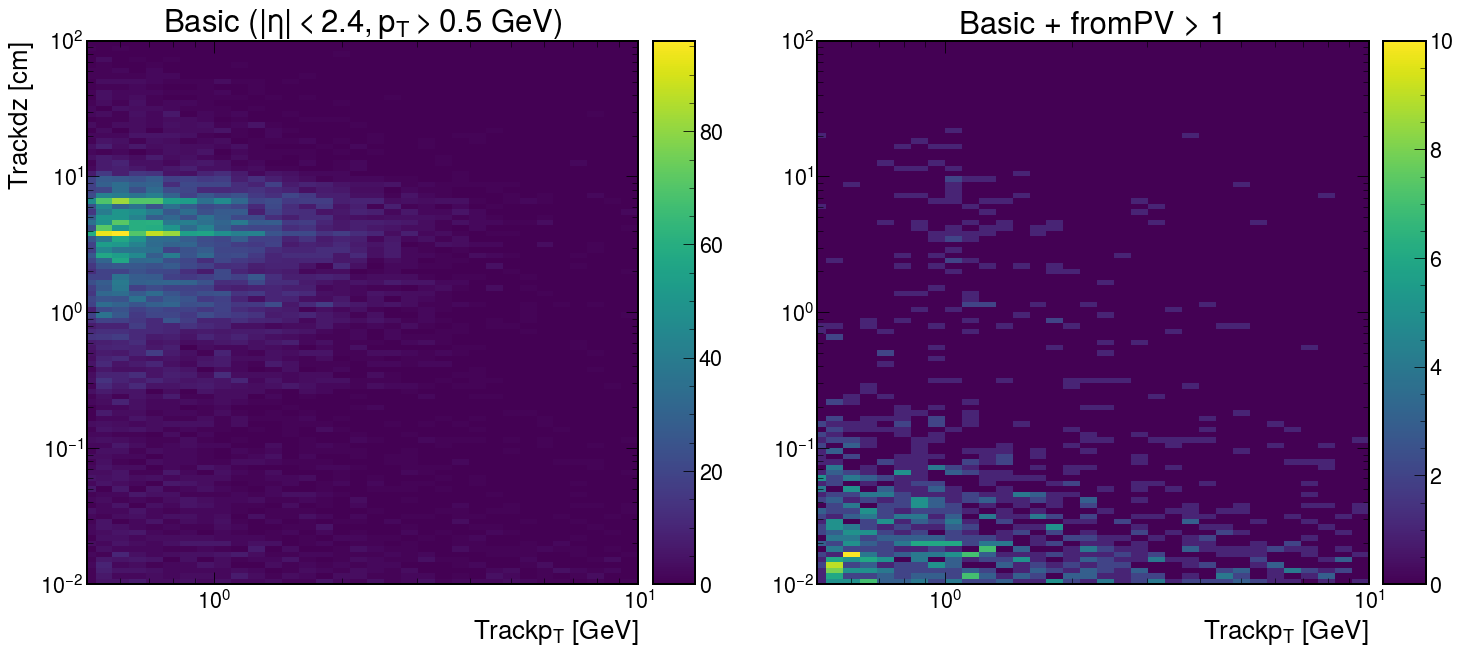

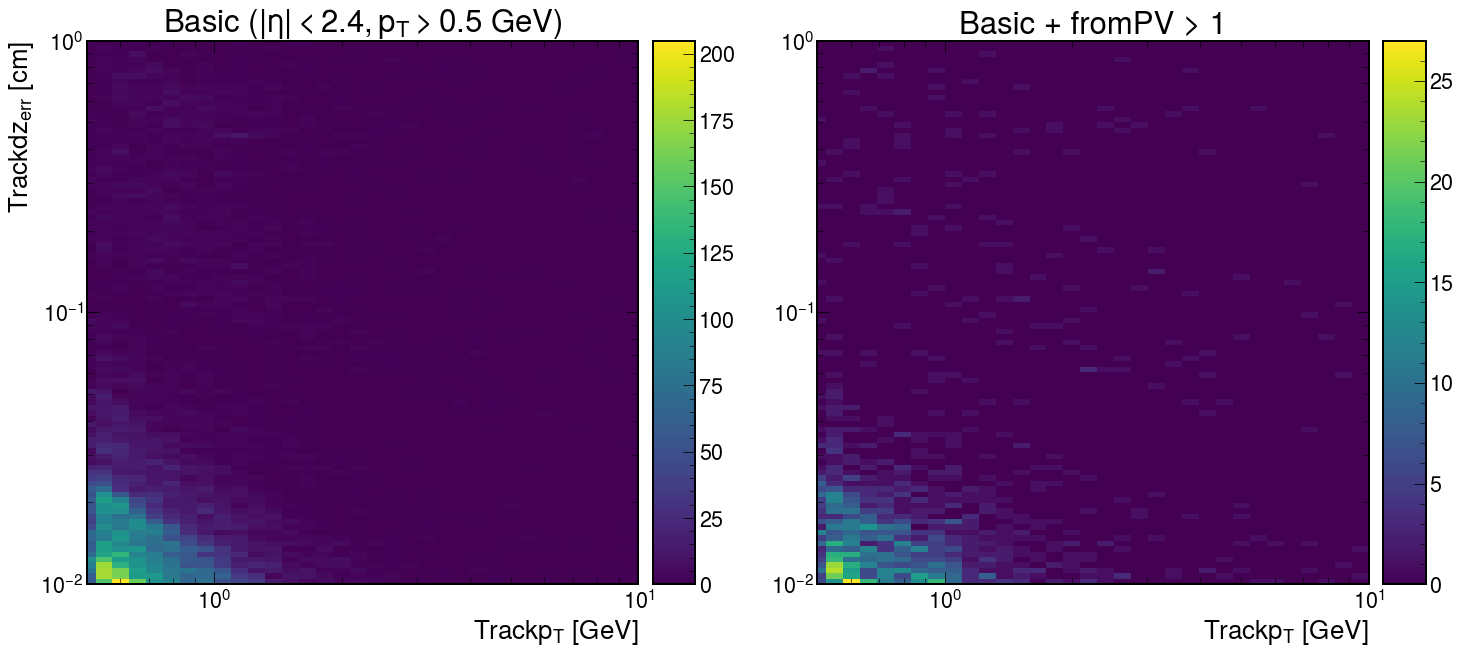

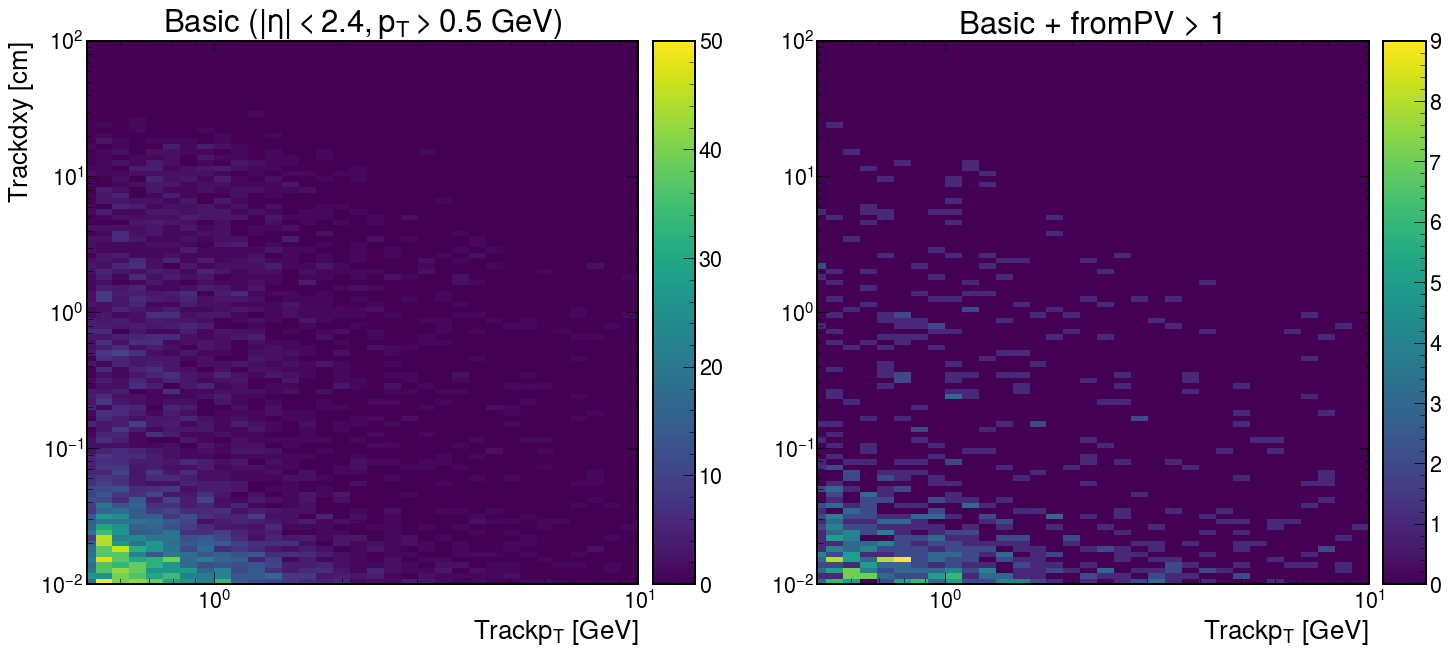

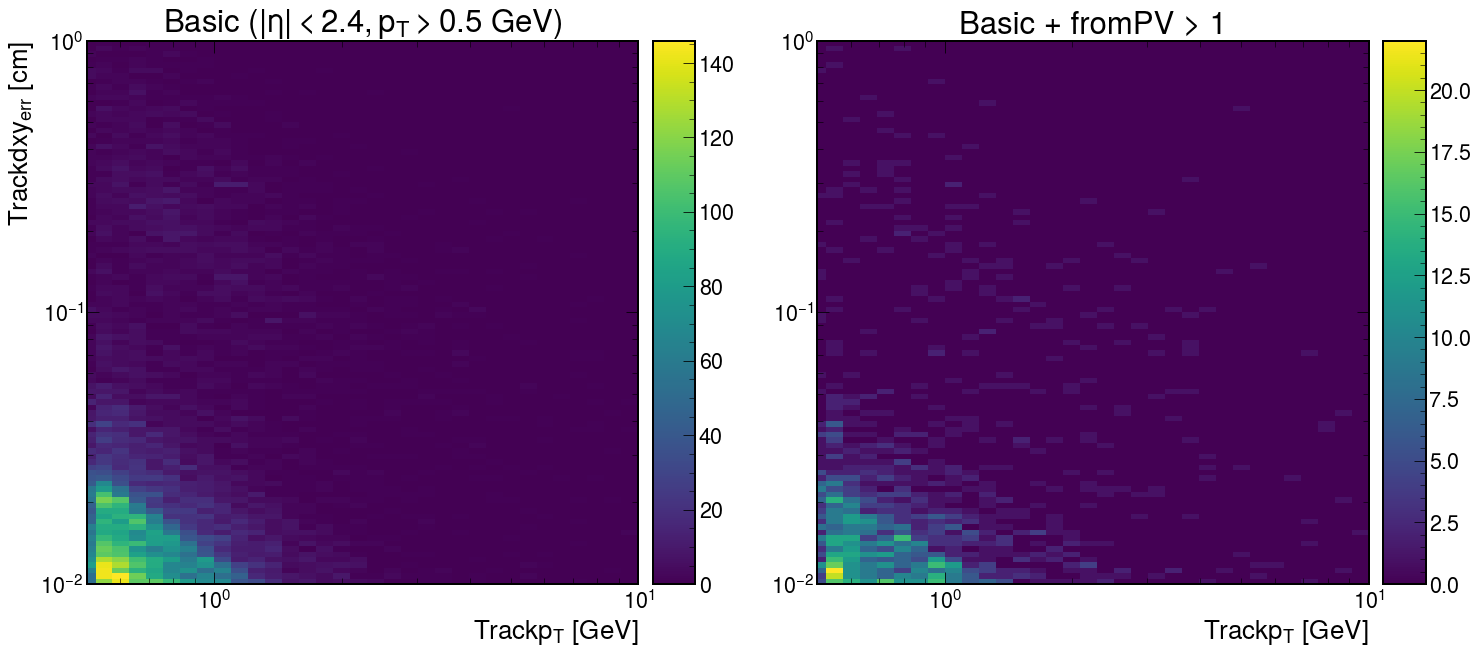

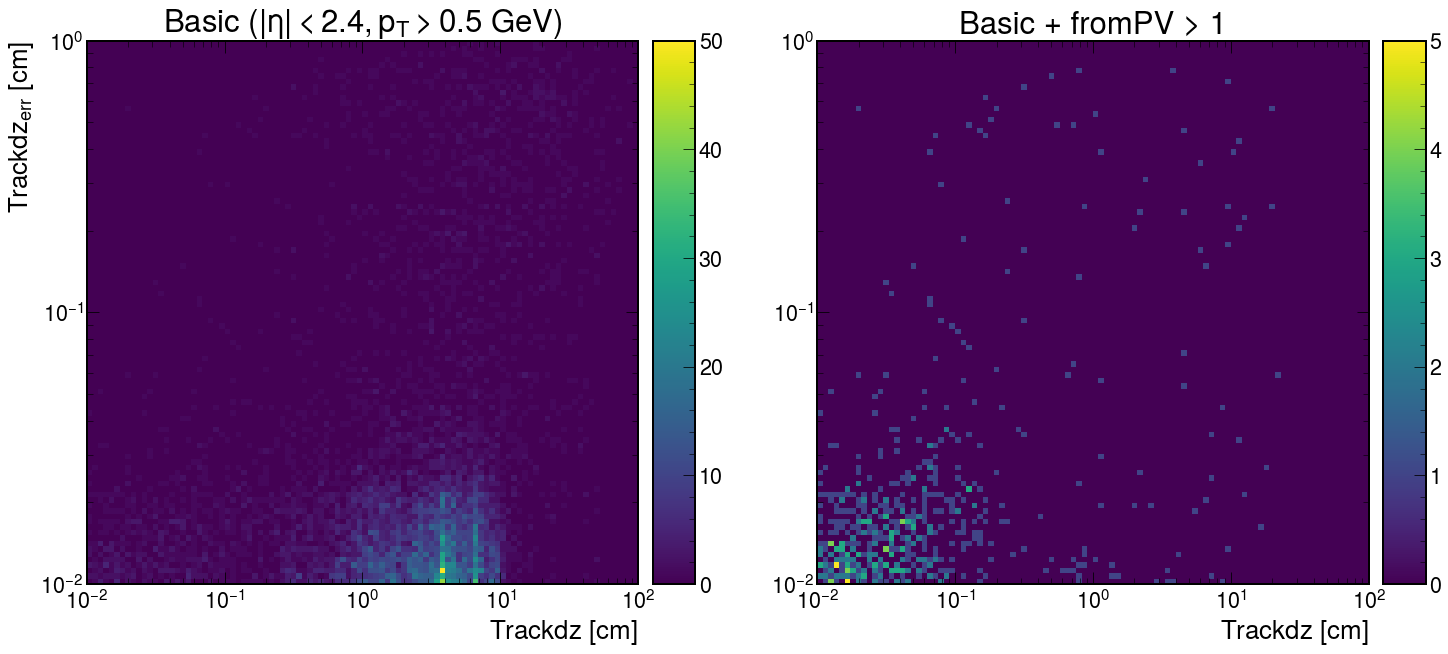

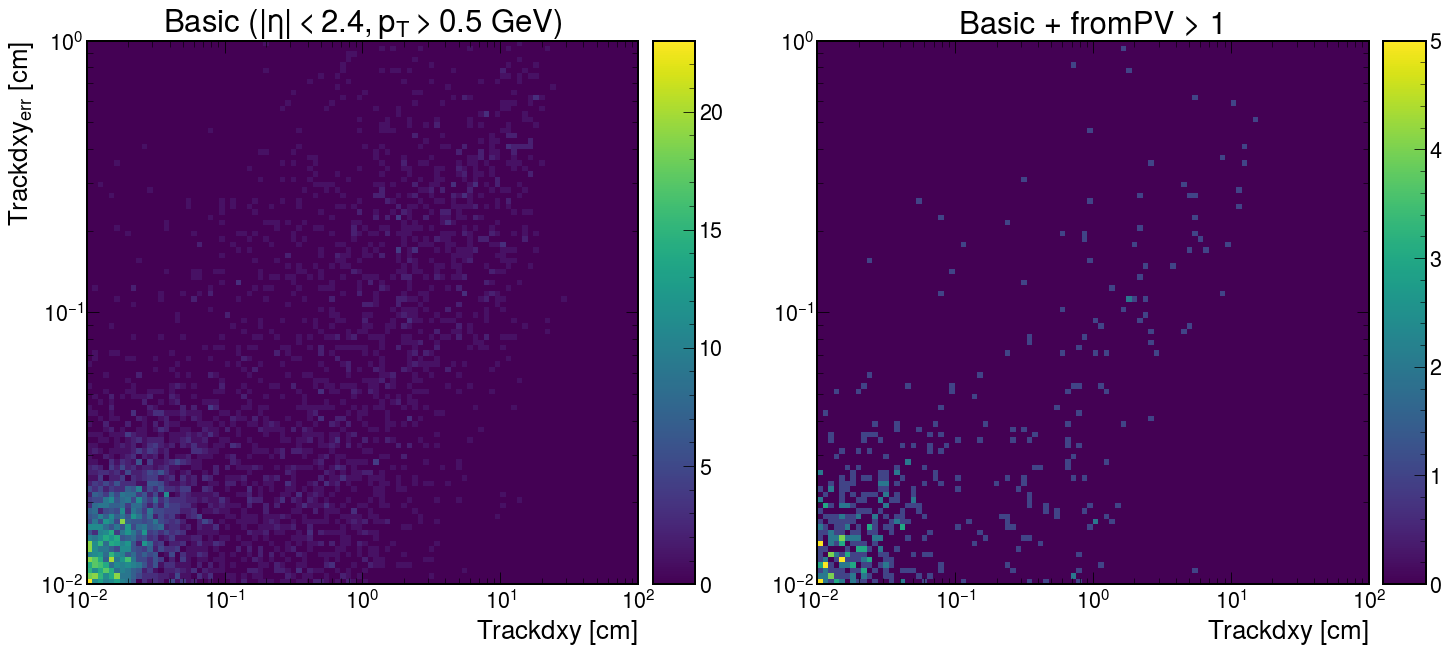

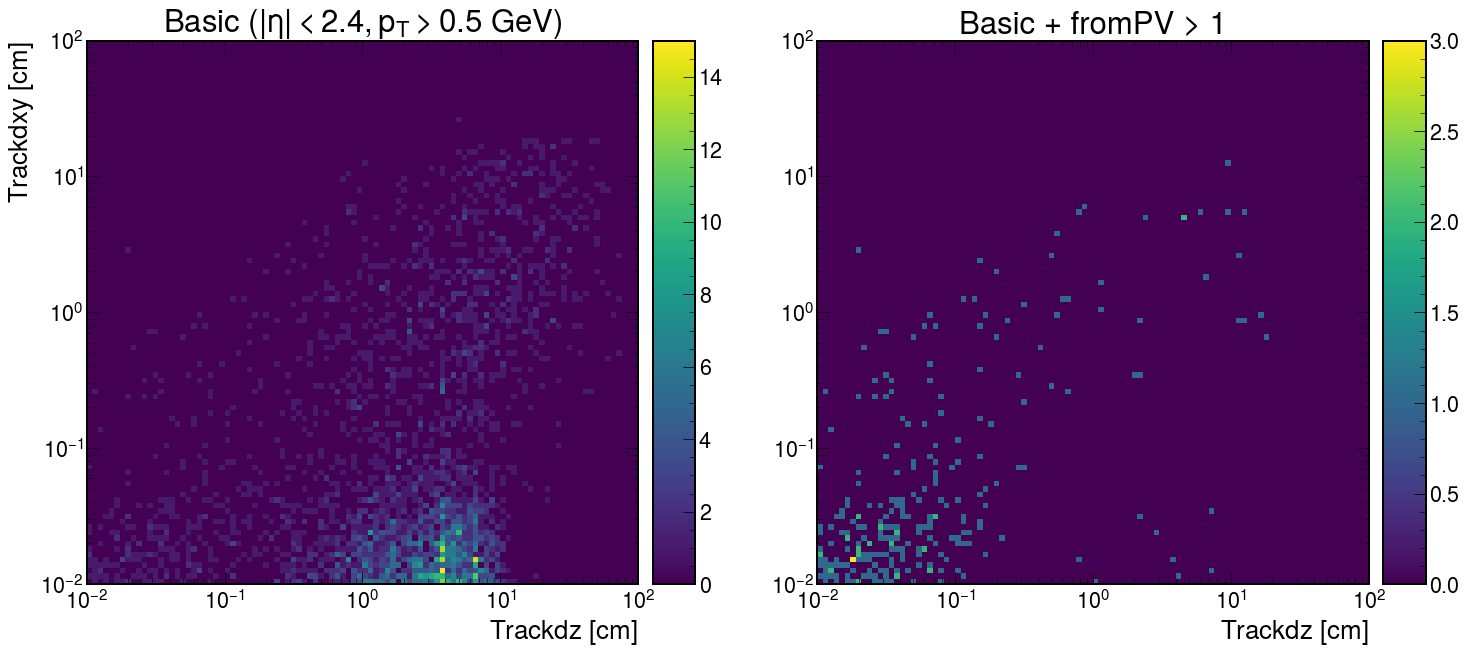

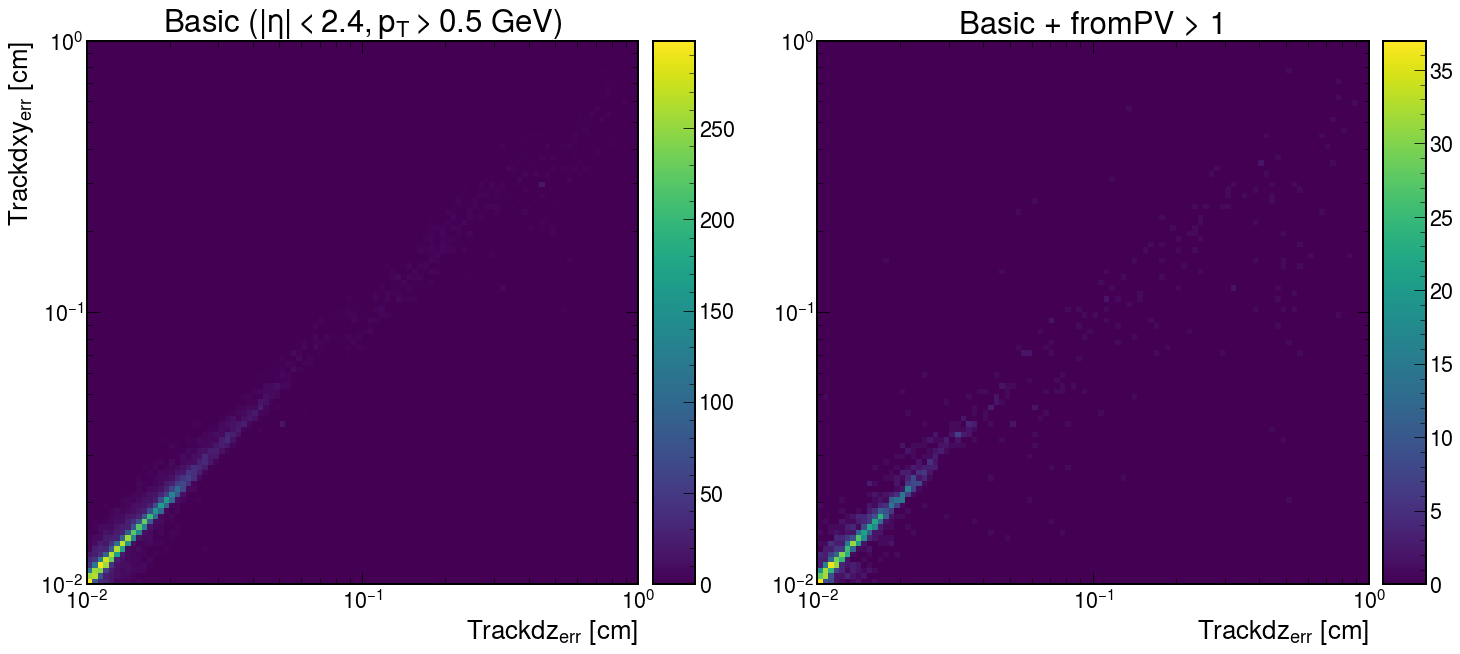

In [12]:
dataset = 'generic_M125_MD2_T2_HT'
plot_labels = [x for x in output.keys() if '_' in x]

for plot_label in plot_labels:

    fig = plt.figure(figsize=(24,10))
    axs = fig.subplots(1,2)

    output[plot_label][dataset,'basic',:,:].plot(ax=axs[0])
    output[plot_label][dataset,'fromPV',:,:].plot(ax=axs[1])

    x_var, y_var = plot_label.split("_")
    axs[0].set_title(r'Basic ($|\eta| < 2.4, p_{T} > 0.5$ GeV)')
    axs[0].set_yscale("log")
    axs[0].set_xscale("log")
    axs[0].set_xlim(lims.get(x_var))
    axs[0].set_ylim(lims.get(y_var))
    axs[1].set_title('Basic + fromPV > 1')
    axs[1].set_yscale("log")
    axs[1].set_xscale("log")
    axs[1].set_ylabel(None)
    axs[1].set_xlim(lims[x_var])
    axs[1].set_ylim(lims[y_var])

    plt.savefig(outDir.format(dataset + "_" + plot_label + '.pdf'), dpi=100)
    plt.savefig(outDir.format(dataset + "_" + plot_label + '.png'), dpi=100)
    
    plt.show()

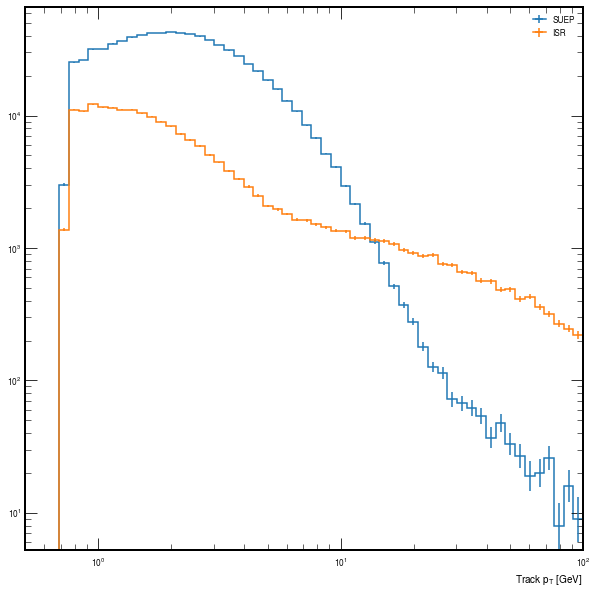

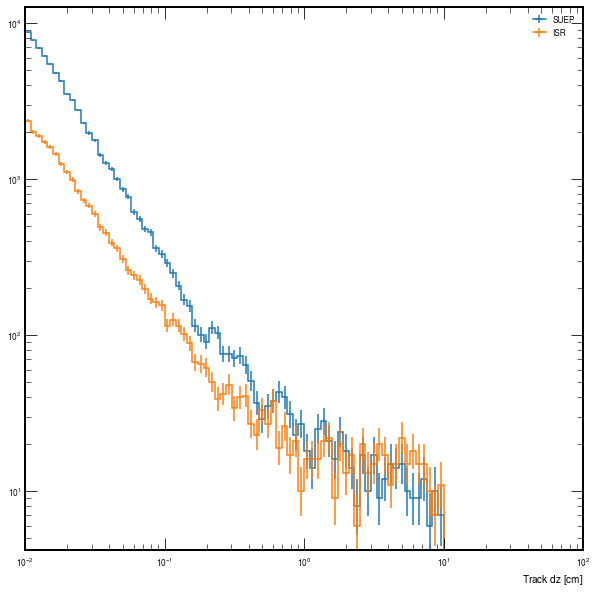

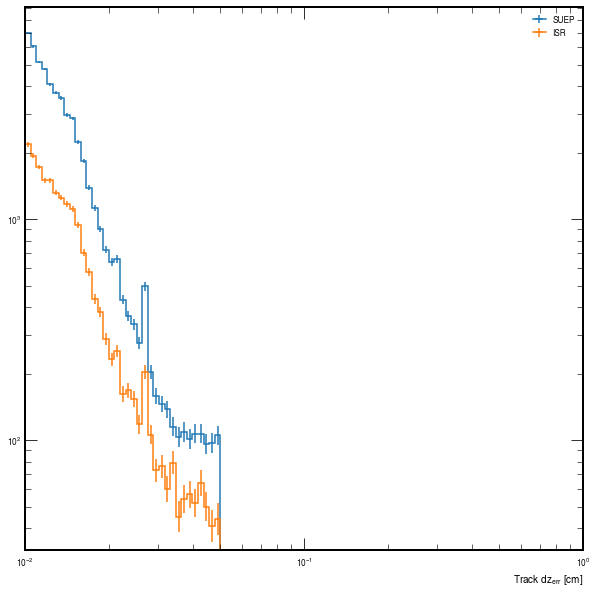

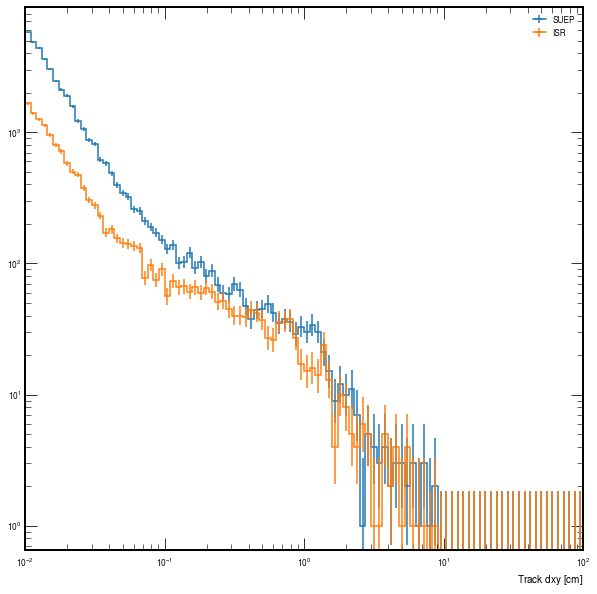

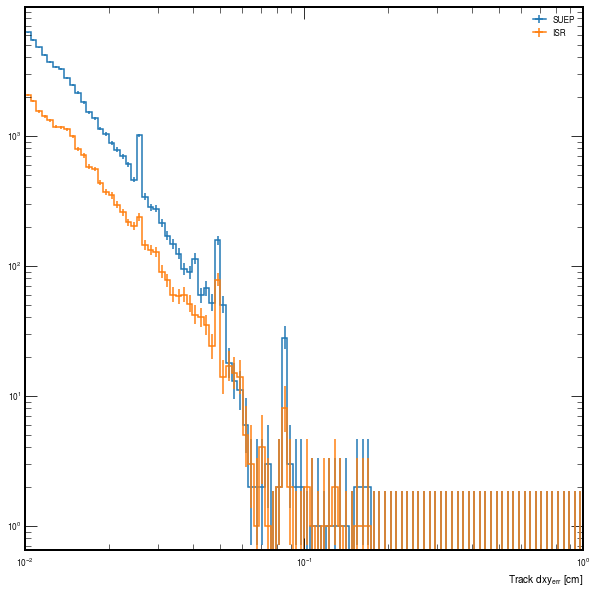

In [13]:
dataset = 'generic_M1000_MD2_T2_HT'
plot_labels = [x for x in output.keys() if '_' in x]

plotted = []
for plot_label in plot_labels:
    
    x_var, y_var = plot_label.split("_")
    
    if x_var not in plotted:

        fig = plt.figure(figsize=(10,10))
        ax = fig.subplots(1)

        output[plot_label][dataset,'SUEP',:,::sum].plot(ax=ax, label='SUEP')
        output[plot_label][dataset,'ISR',:,::sum].plot(ax=ax, label='ISR')

        ax.legend()
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlim(lims.get(x_var))
        
        plt.savefig(outDir.format(dataset + "_" + x_var + '.pdf'), dpi=100)
        plt.savefig(outDir.format(dataset + "_" + x_var + '.png'), dpi=100)
        
        fig.show()
        plotted.append(x_var)
        
    if y_var not in plotted:
    
        fig = plt.figure(figsize=(10,10))
        ax = fig.subplots(1)

        output[plot_label][dataset,'SUEP',::sum,:].plot(ax=ax, label='SUEP')
        output[plot_label][dataset,'ISR',::sum,:].plot(ax=ax, label='ISR')

        ax.legend()
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlim(lims.get(y_var))
        
        plt.savefig(outDir.format(dataset + "_" + y_var + '.pdf'), dpi=100)
        plt.savefig(outDir.format(dataset + "_" + y_var + '.png'), dpi=100)
        
        fig.show()
        plotted.append(y_var)